Notebook em Python criado com o objetivo de realizar o levantamento de tecnicas computacionais e estatísticas (econométricas) para realizar a projeção com a divida confiabilidade de receitas da franqueadora AmorSaúde.

In [76]:
#@title Bibliotecas padrões
import pandas as pd
import pandas.io.sql as sqlio
import sys
import psycopg2
from ydata_profiling import ProfileReport
import numpy as np
from botocore import UNSIGNED
from botocore.config import Config
from urllib.parse import quote_plus
from pyathena import connect
import boto3
import boto3.session
from botocore import exceptions
import seaborn as sns
import plotly.express as px

#Carregando as bibliotecas necessárias para a análise estatística
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 8)
import statsmodels.api as sm
import statsmodels.tsa as tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import arma_generate_sample

In [77]:
#ponte de conexão
connection = psycopg2.connect(dbname="dw_amorsaude",
                                 port = 5439)

Abaixo tentativa de usar redes neurais para predição

In [80]:
df_dre = pd.read_sql_query(df_dre,con=connection)
df_agen = pd.read_sql_query(agendamento,con=connection)

/tmp/ipykernel_2541/529224257.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_dre = pd.read_sql_query(df_dre,con=connection)
/tmp/ipykernel_2541/529224257.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_agen = pd.read_sql_query(agendamento,con=connection)


In [ ]:
#profile = ProfileReport(df_dre, lazy=True, dark_mode=True,  title="Data Profiling AmorSaúde")
#profile.to_notebook_iframe()

In [ ]:
df_agen['id_unidade'] = df_agen['id_unidade'].astype(float)
df_agen['id_unidade'] = df_agen['id_unidade'].ffill()

In [ ]:
df_agen['id_unidade'] = df_agen['id_unidade'].astype(int)

In [ ]:
df_agen['id_unidade'] = df_agen['id_unidade'].astype(str)

In [ ]:
df_agen['id_unidade_data'] = df_agen['id_unidade'] + df_agen['data'].astype(str)
df_dre['id_unidade'] = df_dre['id_unidade'].ffill()
df_dre['id_unidade'] = df_dre['id_unidade'].astype(int)
df_dre['id_unidade'] = df_dre['id_unidade'].astype(str)
df_dre['id_unidade_data'] = df_dre['id_unidade'] + df_dre['data'].astype(str)
merged_df = pd.merge(df_dre, df_agen, on=['id_unidade_data', 'id_unidade_data'])

In [ ]:
#id_unidade_x, meses_inauguraca, id_unidade_y, id_unidade_data, data_y, nome_unidade, regiao
colunas_remover = ["id_unidade_x", "meses_inauguracao", "id_unidade_y", "id_unidade_data", "data_y", "nome_unidade", "regiao"]
df_drop = merged_df.drop(colunas_remover, axis=1)
df_grouped = df_drop.groupby("data_x").sum().reset_index()

In [ ]:
df_grouped['%efetividade_atendimento'] = (df_grouped['qtd_atendimentos'] / df_grouped['qtd_agendamentos']) * 100

In [ ]:
df_grouped.head(5)

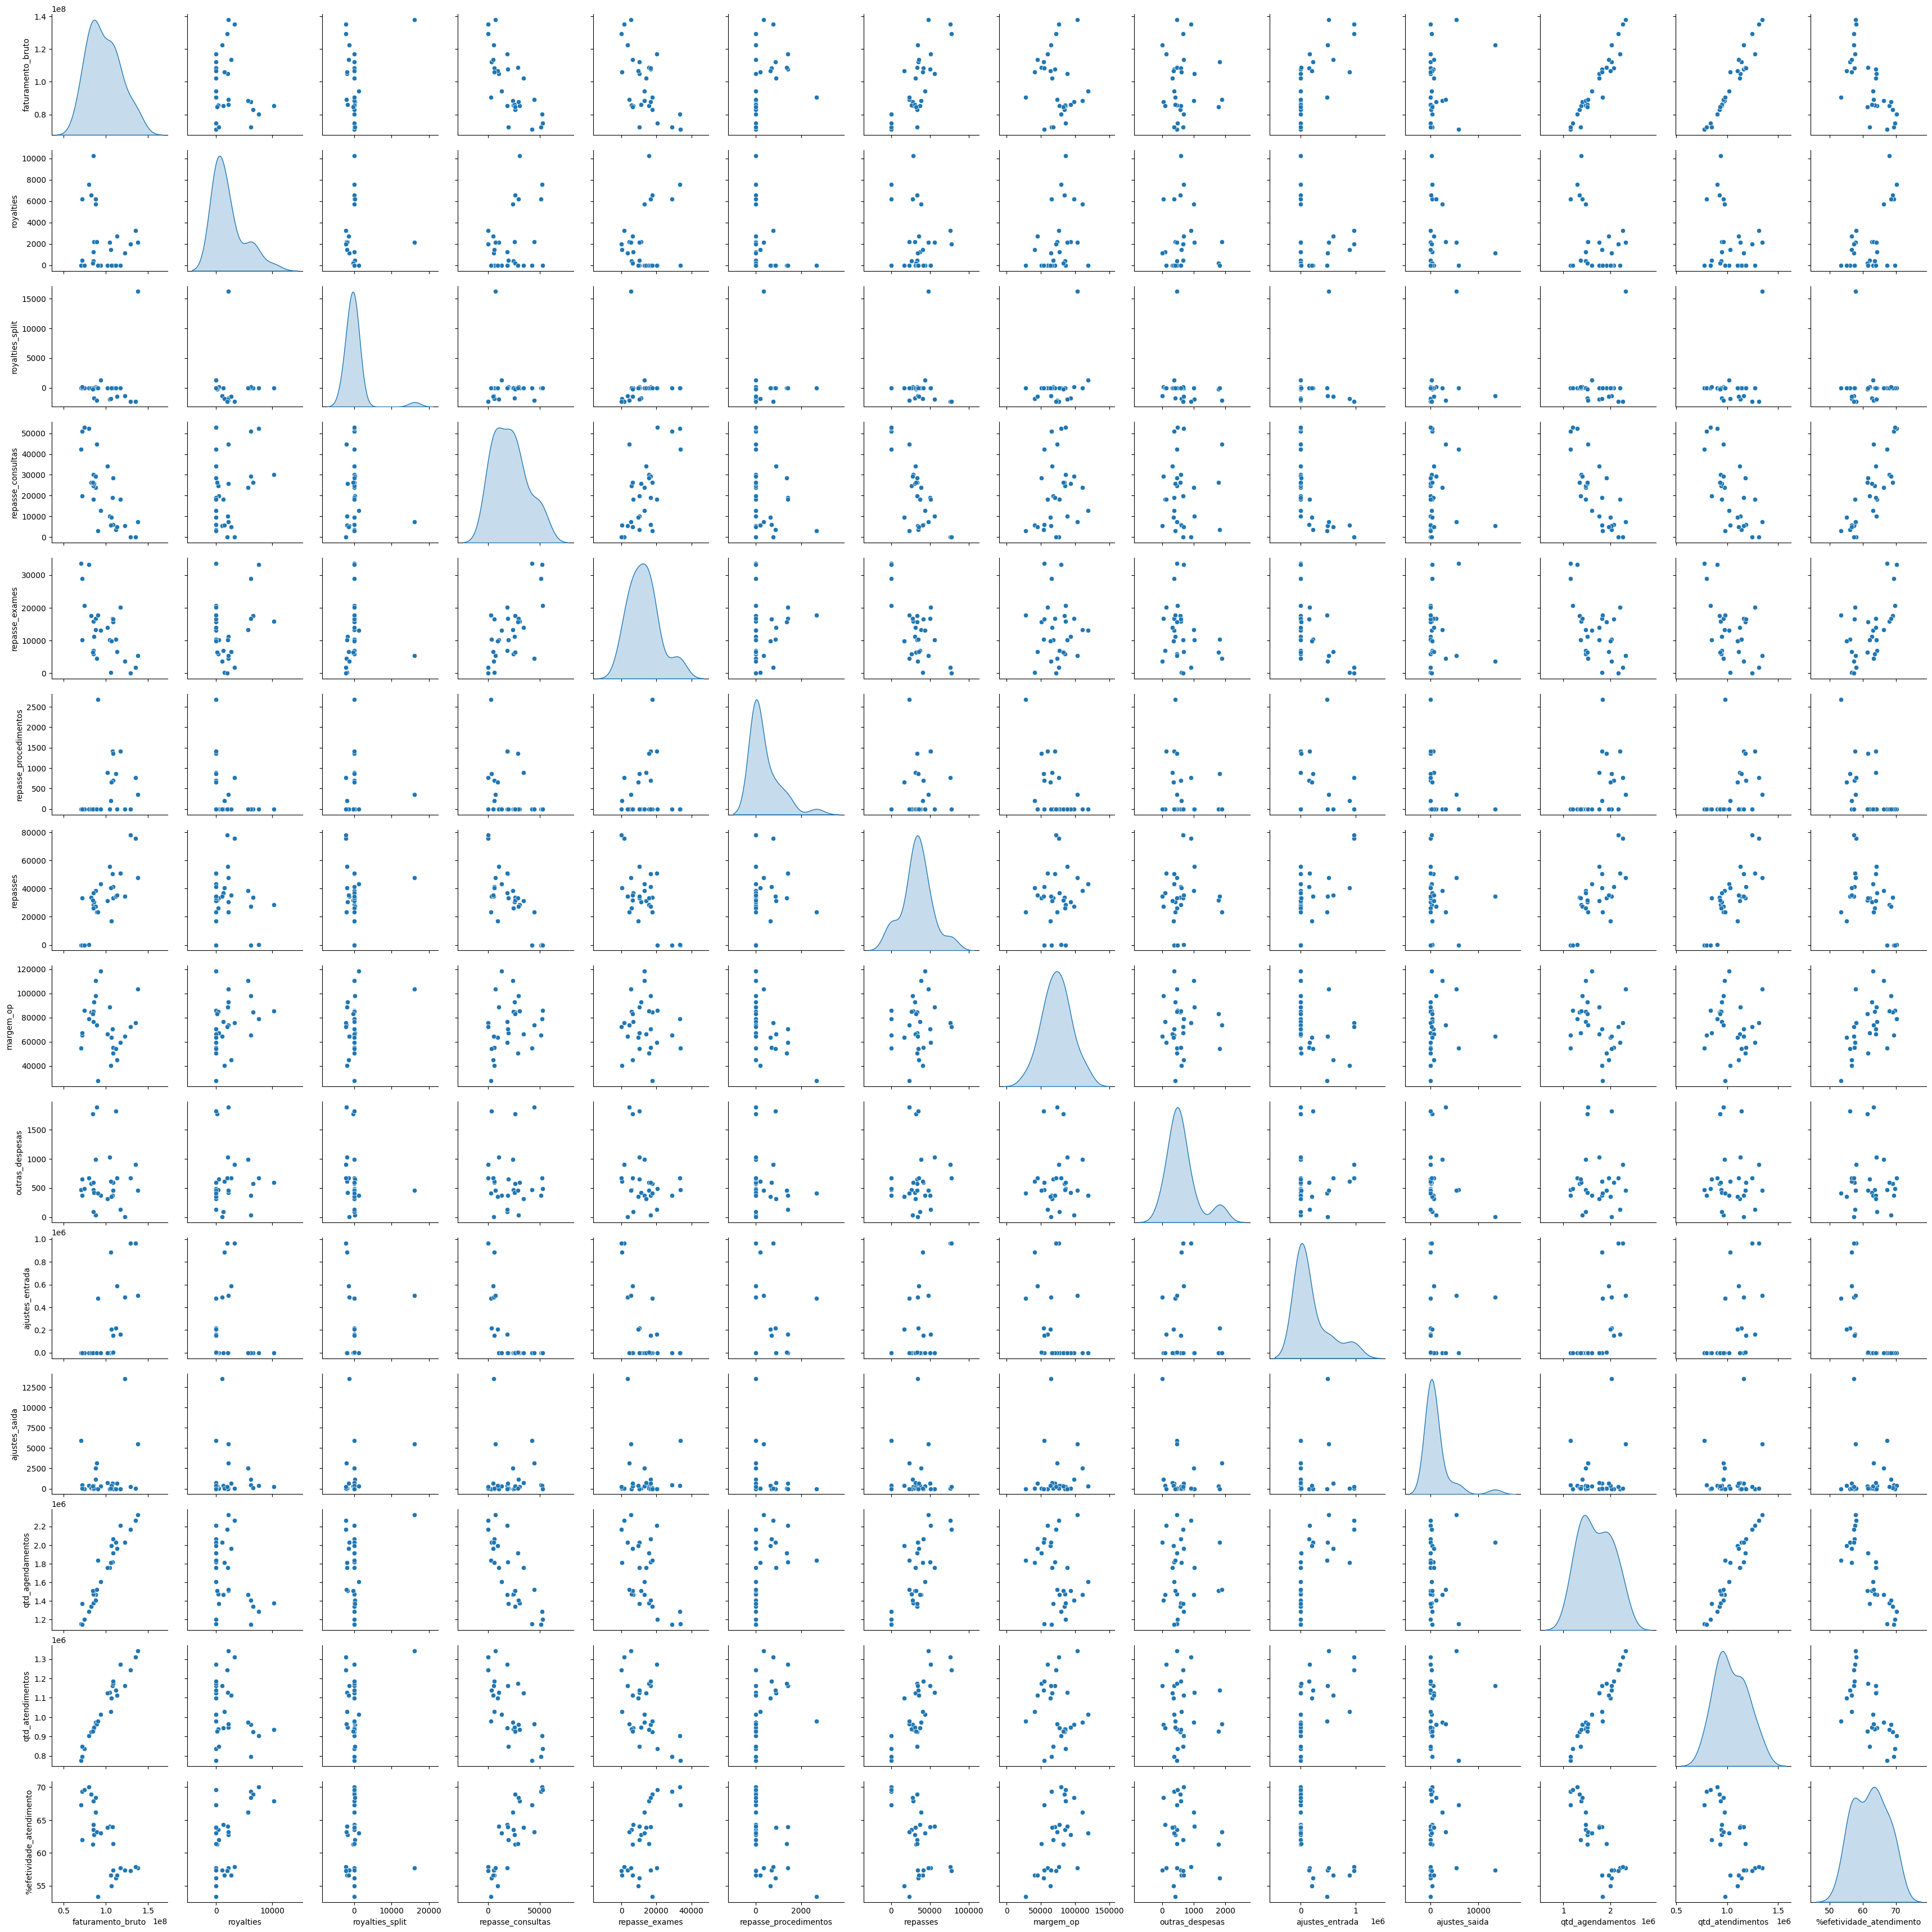

In [ ]:
sns.pairplot(df_grouped.fillna(0),diag_kind="kde", 
                                        vars=['faturamento_bruto', 'royalties', 'royalties_split', 'repasse_consultas', 'repasse_exames', 'repasse_procedimentos', 
                                              'repasses', 'margem_op', 'outras_despesas', 'ajustes_entrada', 'ajustes_saida','qtd_agendamentos', 'qtd_atendimentos',
                                         '%efetividade_atendimento'])

Tentativa de projeção com redes neurais.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

In [ ]:
#Separar as features (data e qtde_registro) e o target (total_recebido)
X = df_grouped[['qtd_agendamentos', 'qtd_atendimentos', 'repasse_consultas', 'repasse_exames', '%efetividade_atendimento']]
y = df_grouped['faturamento_bruto']
#há NaN nos dados, impossibilitando o algoritmo (substituindo vazios por 0)
X.fillna(0, inplace=True)

/tmp/ipykernel_2541/556987834.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


In [ ]:
# Dividir o dataset em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Padronizar as features para terem média zero e desvio padrão um
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Criar e treinar o modelo de regressão com redes neurais
model = MLPRegressor(hidden_layer_sizes=(1000, 500, 400, 300, 200, 100, 25), 
                     activation='relu', solver='adam', random_state=None,
                     alpha=0.0001, batch_size='auto', learning_rate='constant',
                     learning_rate_init=0.001, power_t=0.5, max_iter=200,
                     shuffle=True,tol=0.0001,
                     verbose=False, warm_start=False, momentum=0.9,
                     nesterovs_momentum=True, early_stopping=False,
                     validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                     epsilon=1e-08, n_iter_no_change=10, max_fun=15000)

model.fit(X_train, y_train)



/home/gabriel/anaconda3/envs/.conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(1000, 500, 400, 300, 200, 100, 25))

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print('Erro médio quadrático:', mse)

Erro médio quadrático: 84668203971472.72


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


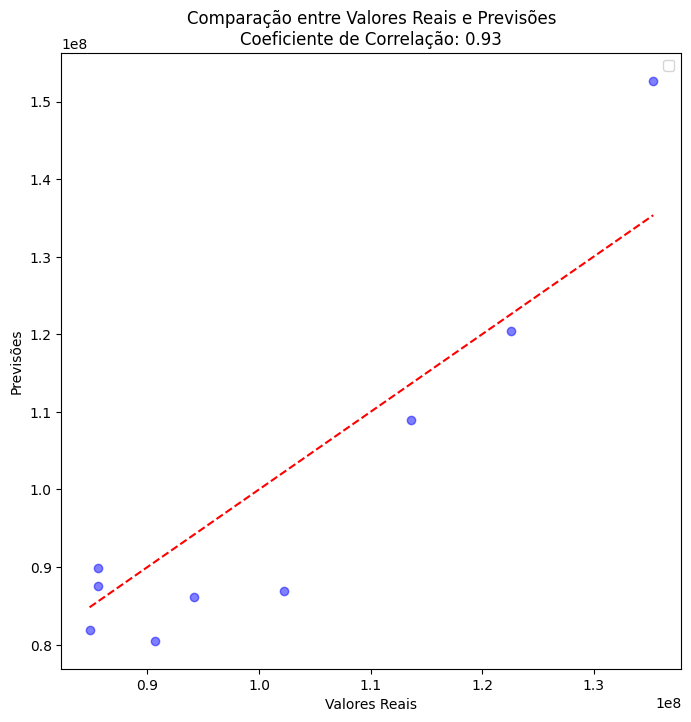

In [ ]:
# Calcular o coeficiente de correlação
correlation = np.corrcoef(y_test, y_pred)[0, 1]

# Criar o gráfico de dispersão com linha de tendência
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, color='b', alpha=0.5)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r', linestyle='--')
ax.set_xlabel('Valores Reais')
ax.set_ylabel('Previsões')
ax.set_title('Comparação entre Valores Reais e Previsões\nCoeficiente de Correlação: {:.2f}'.format(correlation))
ax.legend()
plt.show()

In [ ]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = calculate_mape(y_test, y_pred)
print('Erro Percentual Absoluto Médio (MAPE): {:.2f}%'.format(mape))

Erro Percentual Absoluto Médio (MAPE): 7.14%


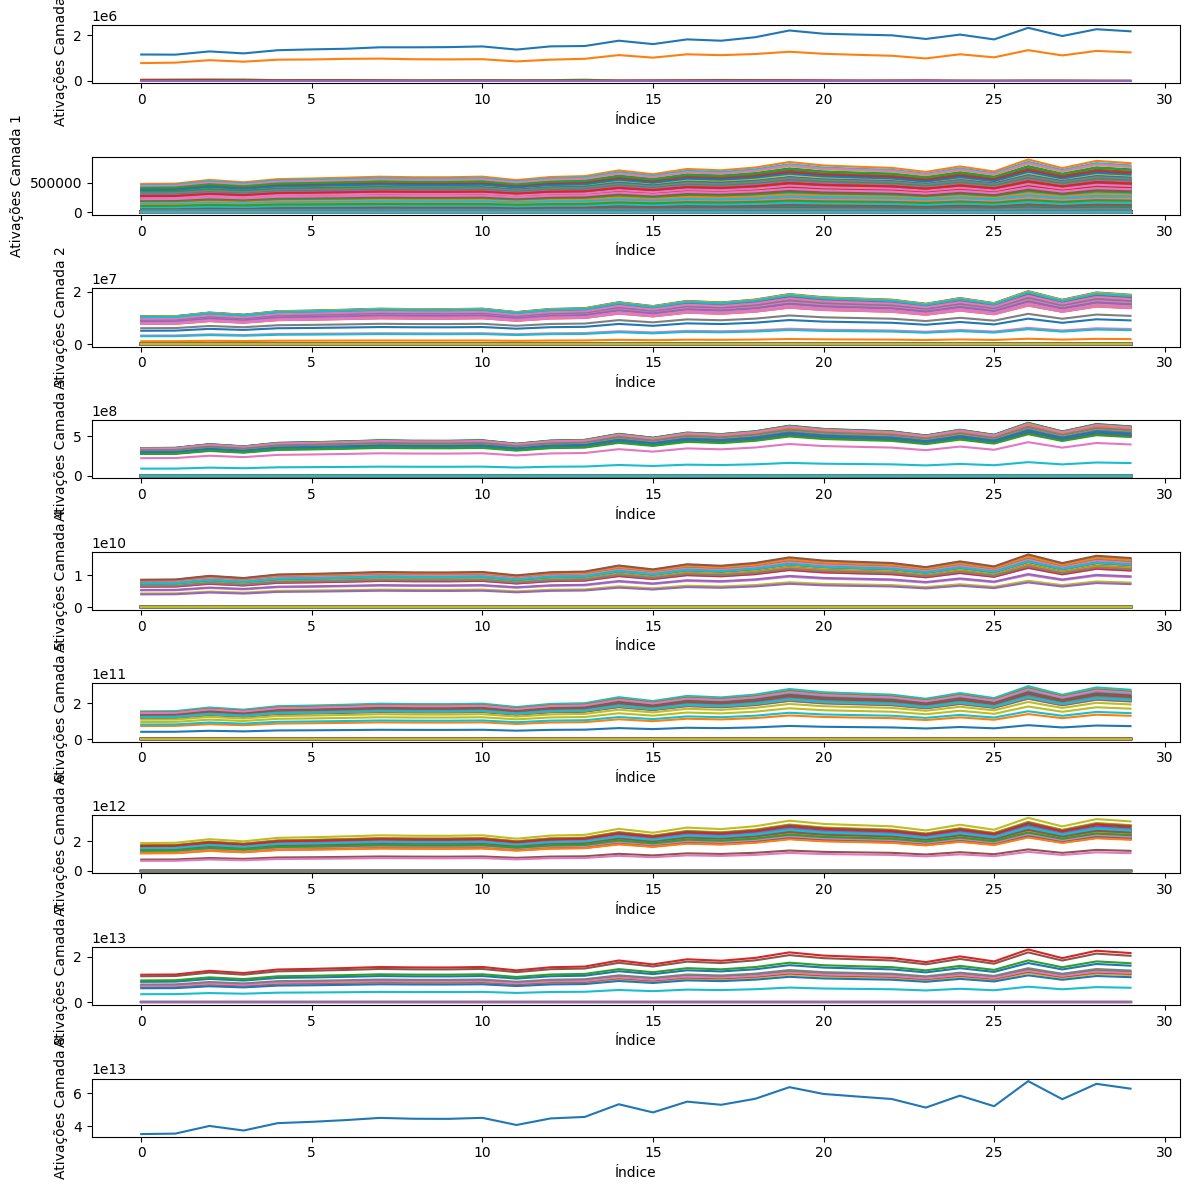

In [ ]:
def get_activations(model, X):
    activations = [X]
    for i in range(len(model.coefs_)):
        activations.append(np.maximum(0, np.dot(activations[-1], model.coefs_[i]) + model.intercepts_[i]))
    return activations

activations = get_activations(model, X)

fig, ax = plt.subplots(len(model.coefs_) + 1, 1, figsize=(12, 12))
for i in range(len(model.coefs_) + 1):
    ax[i].plot(X.index, activations[i])
    ax[i].set_xlabel('Índice')
    ax[i].set_ylabel(f'Ativações Camada {i}')
plt.tight_layout()
plt.show()

In [ ]:
model.fit(X_train, y_train)

/home/gabriel/anaconda3/envs/.conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(1000, 500, 400, 300, 200, 100, 25))

In [ ]:
parametros = model.coefs_
for i, param in enumerate(parametros):
    print(f'Camada {i+1}: {param.shape}') # Exibe a forma da matriz de pesos

Camada 1: (5, 1000)
Camada 2: (1000, 500)
Camada 3: (500, 400)
Camada 4: (400, 300)
Camada 5: (300, 200)
Camada 6: (200, 100)
Camada 7: (100, 25)
Camada 8: (25, 1)


Tentativa de projeção com o Prophet do facebook

In [ ]:
from prophet import Prophet

In [ ]:
df_grouped_index = df_grouped.reset_index()
df_grouped_index.head(5)

In [ ]:
df3 = df_grouped_index[['data_x', 'faturamento_bruto']]
df3.columns = ['ds', 'y']

In [ ]:
df_index = df_grouped_index.set_index('data_x', inplace=True)

In [ ]:
model = Prophet()
model.fit(df3)

10:43:24 - cmdstanpy - INFO - Chain [1] start processing
10:43:24 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=12, freq='MS')  # Prever os próximos 12 meses

In [ ]:
forecast = model.predict(future)

In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,6.977951e+07,6.557970e+07,6.975648e+07,6.977951e+07,6.977951e+07,-2.156203e+06,-2.156203e+06,-2.156203e+06,-2.156203e+06,-2.156203e+06,-2.156203e+06,0.0,0.0,0.0,6.762330e+07
1,2021-02-01,7.129811e+07,7.094359e+07,7.487464e+07,7.129811e+07,7.129811e+07,1.608368e+06,1.608368e+06,1.608368e+06,1.608368e+06,1.608368e+06,1.608368e+06,0.0,0.0,0.0,7.290647e+07
2,2021-03-01,7.266974e+07,7.781424e+07,8.185310e+07,7.266974e+07,7.266974e+07,7.236076e+06,7.236076e+06,7.236076e+06,7.236076e+06,7.236076e+06,7.236076e+06,0.0,0.0,0.0,7.990582e+07
3,2021-04-01,7.418834e+07,7.389918e+07,7.797008e+07,7.418834e+07,7.418834e+07,1.783448e+06,1.783448e+06,1.783448e+06,1.783448e+06,1.783448e+06,1.783448e+06,0.0,0.0,0.0,7.597179e+07
4,2021-05-01,7.565814e+07,8.201953e+07,8.606982e+07,7.565814e+07,7.565814e+07,8.369770e+06,8.369770e+06,8.369770e+06,8.369770e+06,8.369770e+06,8.369770e+06,0.0,0.0,0.0,8.402791e+07
5,2021-06-01,7.717857e+07,8.291965e+07,8.695009e+07,7.717857e+07,7.717857e+07,7.815181e+06,7.815181e+06,7.815181e+06,7.815181e+06,7.815181e+06,7.815181e+06,0.0,0.0,0.0,8.499375e+07
6,2021-07-01,7.865221e+07,8.711698e+07,9.096754e+07,7.865221e+07,7.865221e+07,1.045713e+07,1.045713e+07,1.045713e+07,1.045713e+07,1.045713e+07,1.045713e+07,0.0,0.0,0.0,8.910933e+07
7,2021-08-01,8.017880e+07,8.709317e+07,9.125618e+07,8.017880e+07,8.017880e+07,8.947897e+06,8.947897e+06,8.947897e+06,8.947897e+06,8.947897e+06,8.947897e+06,0.0,0.0,0.0,8.912669e+07
8,2021-09-01,8.170864e+07,8.369076e+07,8.787157e+07,8.170864e+07,8.170864e+07,4.049205e+06,4.049205e+06,4.049205e+06,4.049205e+06,4.049205e+06,4.049205e+06,0.0,0.0,0.0,8.575785e+07
9,2021-10-01,8.319035e+07,8.296454e+07,8.727443e+07,8.319035e+07,8.319035e+07,1.965979e+06,1.965979e+06,1.965979e+06,1.965979e+06,1.965979e+06,1.965979e+06,0.0,0.0,0.0,8.515633e+07


In [ ]:
ultima_previsao = print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12))  # Últimas 12 previsões

           ds          yhat    yhat_lower    yhat_upper
30 2023-07-01  1.297238e+08  1.276795e+08  1.318812e+08
31 2023-08-01  1.469592e+08  1.449571e+08  1.490318e+08
32 2023-09-01  1.335680e+08  1.313855e+08  1.357182e+08
33 2023-10-01  1.417113e+08  1.396425e+08  1.437778e+08
34 2023-11-01  1.313395e+08  1.292826e+08  1.334961e+08
35 2023-12-01  1.137387e+08  1.116914e+08  1.158925e+08
36 2024-01-01  1.510972e+08  1.488941e+08  1.532082e+08
37 2024-02-01  1.290806e+08  1.271126e+08  1.311174e+08
38 2024-03-01  1.446399e+08  1.424485e+08  1.467328e+08
39 2024-04-01  1.514564e+08  1.491081e+08  1.536245e+08
40 2024-05-01  1.541803e+08  1.518127e+08  1.566250e+08
41 2024-06-01  1.602787e+08  1.580303e+08  1.625607e+08


In [ ]:
# Transformar valores em notação científica para decimal
forecast1[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']].apply(lambda x: x.apply('{:.8f}'.format))

NameError: name 'forecast1' is not defined

In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,6.977951e+07,6.557970e+07,6.975648e+07,6.977951e+07,6.977951e+07,-2.156203e+06,-2.156203e+06,-2.156203e+06,-2.156203e+06,-2.156203e+06,-2.156203e+06,0.0,0.0,0.0,6.762330e+07
1,2021-02-01,7.129811e+07,7.094359e+07,7.487464e+07,7.129811e+07,7.129811e+07,1.608368e+06,1.608368e+06,1.608368e+06,1.608368e+06,1.608368e+06,1.608368e+06,0.0,0.0,0.0,7.290647e+07
2,2021-03-01,7.266974e+07,7.781424e+07,8.185310e+07,7.266974e+07,7.266974e+07,7.236076e+06,7.236076e+06,7.236076e+06,7.236076e+06,7.236076e+06,7.236076e+06,0.0,0.0,0.0,7.990582e+07
3,2021-04-01,7.418834e+07,7.389918e+07,7.797008e+07,7.418834e+07,7.418834e+07,1.783448e+06,1.783448e+06,1.783448e+06,1.783448e+06,1.783448e+06,1.783448e+06,0.0,0.0,0.0,7.597179e+07
4,2021-05-01,7.565814e+07,8.201953e+07,8.606982e+07,7.565814e+07,7.565814e+07,8.369770e+06,8.369770e+06,8.369770e+06,8.369770e+06,8.369770e+06,8.369770e+06,0.0,0.0,0.0,8.402791e+07
5,2021-06-01,7.717857e+07,8.291965e+07,8.695009e+07,7.717857e+07,7.717857e+07,7.815181e+06,7.815181e+06,7.815181e+06,7.815181e+06,7.815181e+06,7.815181e+06,0.0,0.0,0.0,8.499375e+07
6,2021-07-01,7.865221e+07,8.711698e+07,9.096754e+07,7.865221e+07,7.865221e+07,1.045713e+07,1.045713e+07,1.045713e+07,1.045713e+07,1.045713e+07,1.045713e+07,0.0,0.0,0.0,8.910933e+07
7,2021-08-01,8.017880e+07,8.709317e+07,9.125618e+07,8.017880e+07,8.017880e+07,8.947897e+06,8.947897e+06,8.947897e+06,8.947897e+06,8.947897e+06,8.947897e+06,0.0,0.0,0.0,8.912669e+07
8,2021-09-01,8.170864e+07,8.369076e+07,8.787157e+07,8.170864e+07,8.170864e+07,4.049205e+06,4.049205e+06,4.049205e+06,4.049205e+06,4.049205e+06,4.049205e+06,0.0,0.0,0.0,8.575785e+07
9,2021-10-01,8.319035e+07,8.296454e+07,8.727443e+07,8.319035e+07,8.319035e+07,1.965979e+06,1.965979e+06,1.965979e+06,1.965979e+06,1.965979e+06,1.965979e+06,0.0,0.0,0.0,8.515633e+07


In [ ]:
nome_do_arquivo = 'projecao.xlsx'
forecast.to_excel(nome_do_arquivo, index=False)  # O argumento 'index=False' evita salvar o índice do DataFrame no Excel

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcular as previsões do modelo
y_pred = forecast['yhat'].tail(len(y_test))  # Usar as previsões correspondentes ao conjunto de teste

# Calcular as métricas de desempenho
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Exibir as métricas
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:", mape)

MAE: 40322820.14329032
MSE: 1935779444309469.2
RMSE: 43997493.613948844
MAPE: nan


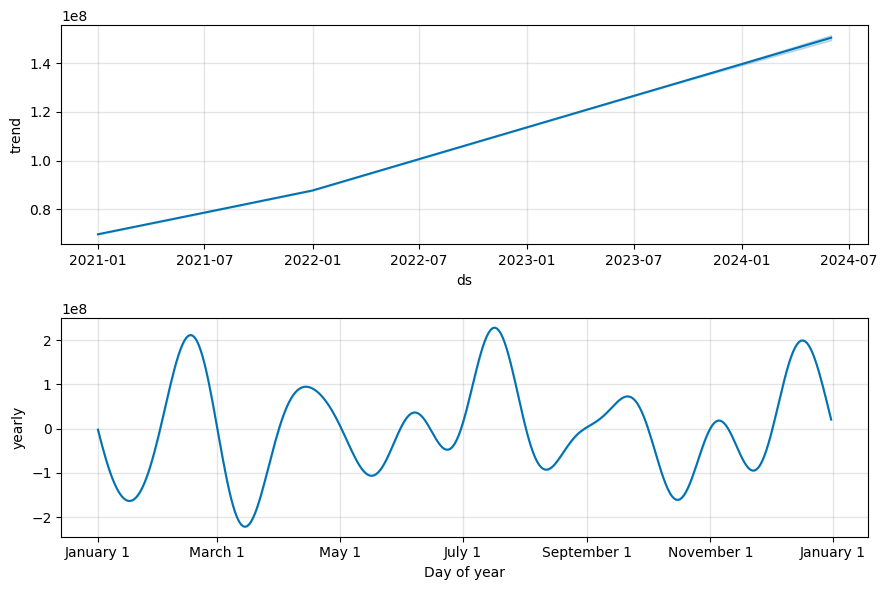

In [ ]:
model.plot_components(forecast);

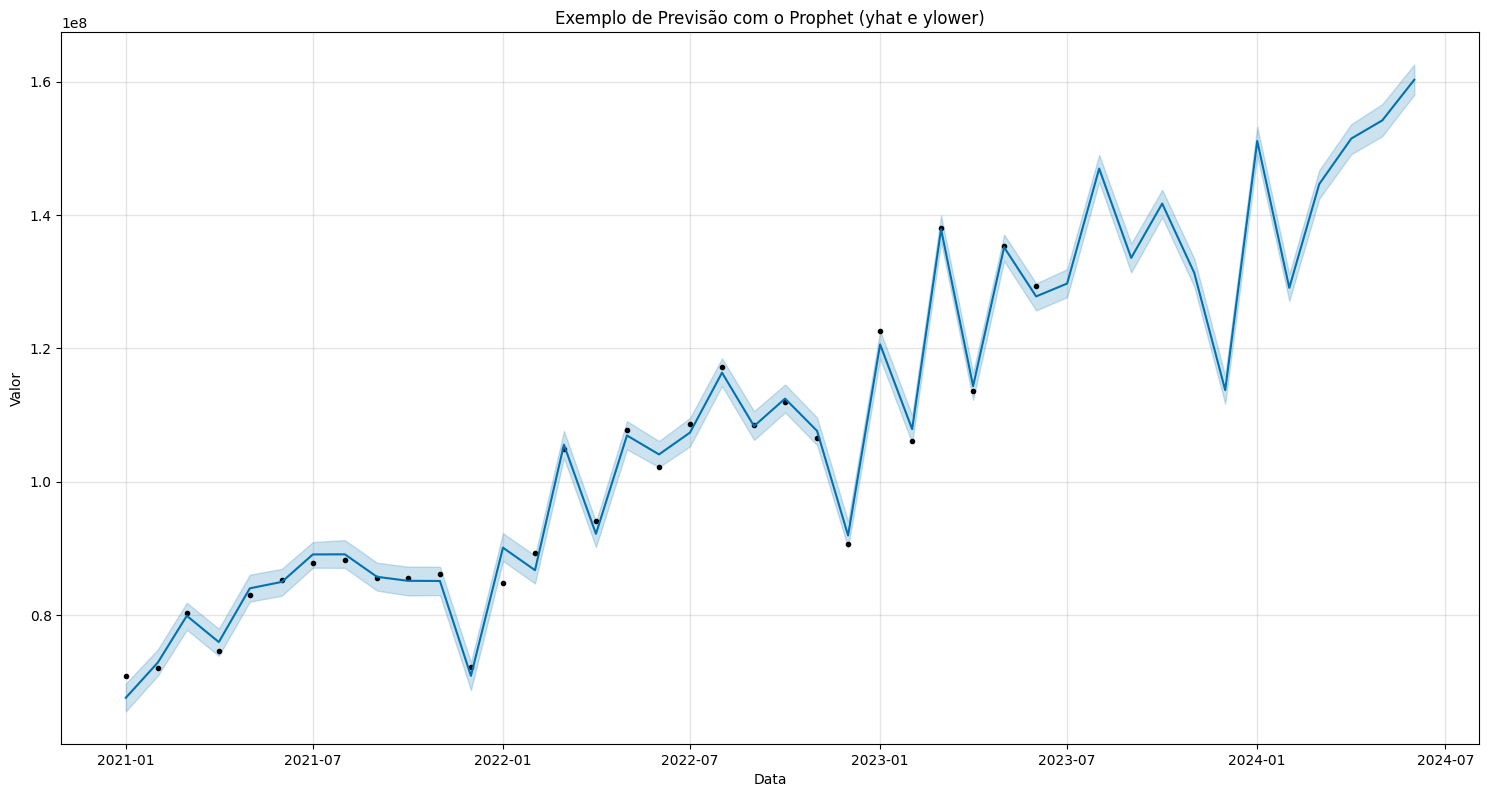

In [ ]:
# Plotando o gráfico com os valores de yhat e ylower
fig, ax = plt.subplots(figsize=(15, 8))
model.plot(forecast, ax=ax, uncertainty=True)
ax.set_title('Exemplo de Previsão com o Prophet (yhat e ylower)')
ax.set_xlabel('Data')
ax.set_ylabel('Valor')
plt.show()

Projeção utilizando séries temporais no sentido de AR (modelo econométrico)

Foi escolhido a biblioteca SARIMAX por conta dos parâmetros alternativos, possibilitando ajustar melhor o modelo de acordo com estatísticas dos resíduos e suas respectivas defasagens. 

In [ ]:
#query
receita_bruta = 'select rf.data , count(*) as qtde_registro, sum(rf.total_recebido) as total_recebido from tb_consolidacao_receita_bruta_hist_final rf group by rf.data order by rf.data' 

In [ ]:
df = pd.read_sql_query(receita_bruta,con=connection)
df['data'] = pd.to_datetime(df['data'])
df.set_index('data', inplace=True)

/tmp/ipykernel_2541/2579268054.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(receita_bruta,con=connection)


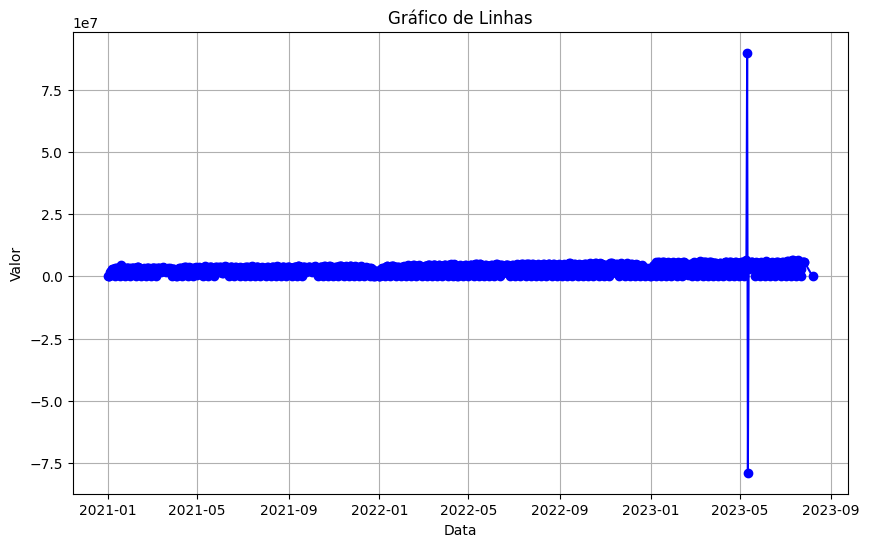

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['total_recebido'], marker='o', linestyle='-', color='blue')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Gráfico de Linhas')
plt.grid(True)
plt.show()

In [ ]:
df1 = pd.read_sql_query(receita_bruta,con=connection)


/tmp/ipykernel_2541/2180129812.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df1 = pd.read_sql_query(receita_bruta,con=connection)


In [ ]:
data_inicio1 = pd.to_datetime('2021-01-01')
data_fim2 = pd.to_datetime('2023-06-30')
df1 = df1[df1['data'].between(data_inicio1, data_fim2)]
df1['data'] = pd.to_datetime(df1['data'])

df1 = pd.DataFrame(df1)

df1.set_index('data', inplace=True)

/tmp/ipykernel_2541/3048780510.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df1 = df1[df1['data'].between(data_inicio1, data_fim2)]


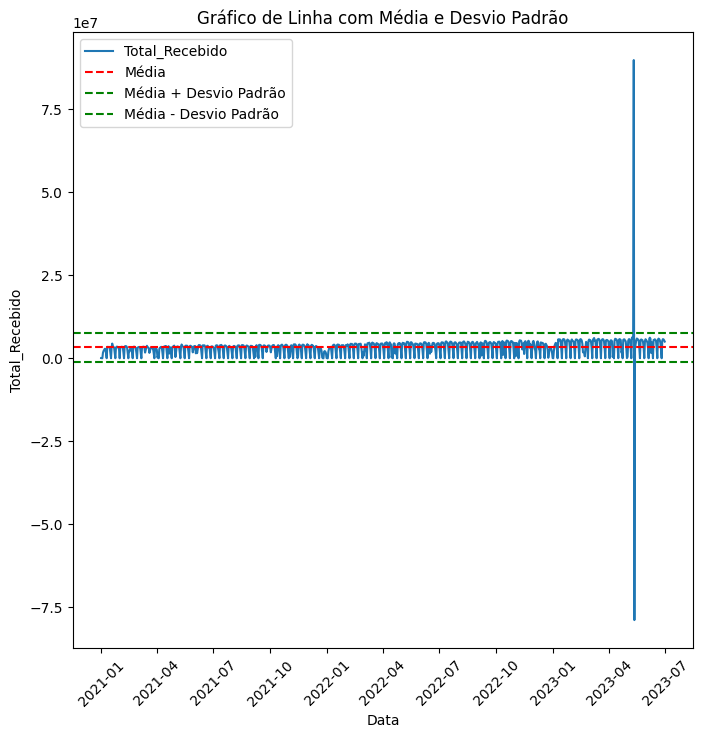

In [ ]:
# Calcular a média e o desvio padrão dos valores de 'Total_Recebido'
mean = df1['total_recebido'].mean()
std = df1['total_recebido'].std()

# Plotar o gráfico de linha
plt.plot(df1['total_recebido'], label='Total_Recebido')

plt.axhline(mean, color='r', linestyle='--', label='Média')
plt.axhline(mean + std, color='g', linestyle='--', label='Média + Desvio Padrão')
plt.axhline(mean - std, color='g', linestyle='--', label='Média - Desvio Padrão')

# Configurar os rótulos e título do gráfico
plt.xlabel('Data')
plt.ylabel('Total_Recebido')
plt.title('Gráfico de Linha com Média e Desvio Padrão')

# Exibir a legenda
plt.legend()

# Girar os rótulos do eixo x para melhor visualização
plt.xticks(rotation=45)

# Exibir o gráfico
plt.show()

In [ ]:
#Separação do dataset, transformação em pd.data series, retirada de valores nulos e colocando em frequencia diária (reapontamento)
df1 = df1['total_recebido']
df1 = pd.DataFrame(df1)
df1['total_recebido'] = df1['total_recebido'].ffill()
df1 = df1.asfreq('D')
print(df1)

            total_recebido
data                      
2021-01-01        61046.43
2021-01-02        40236.90
2021-01-03            0.01
2021-01-04      1672467.89
2021-01-05      2206462.16
...                    ...
2023-06-26      5271646.30
2023-06-27      5759073.61
2023-06-28      5693148.81
2023-06-29      5404485.18
2023-06-30      5025569.16

[911 rows x 1 columns]


/tmp/ipykernel_2541/4068565417.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['total_recebido'], color="m", axlabel='Price')


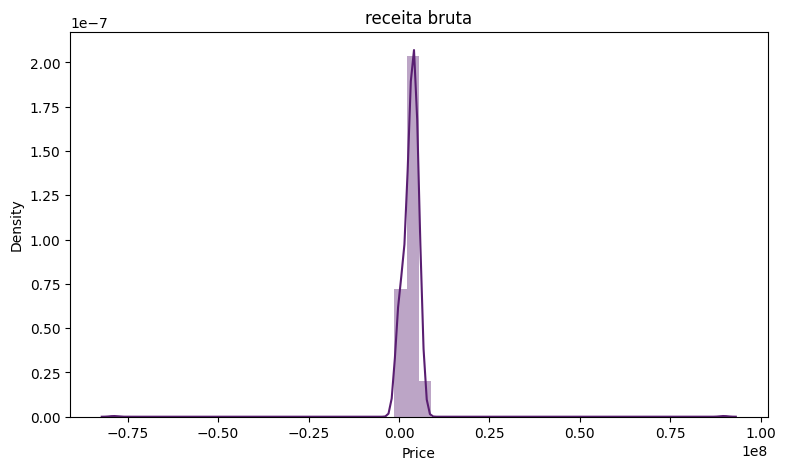

In [ ]:
sns.set_color_codes(palette='dark')

f, ax = plt.subplots(figsize=(9, 5))
sns.distplot(df1['total_recebido'], color="m", axlabel='Price')
ax.set(title="receita bruta")
plt.show()

/home/gabriel/anaconda3/envs/.conda/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


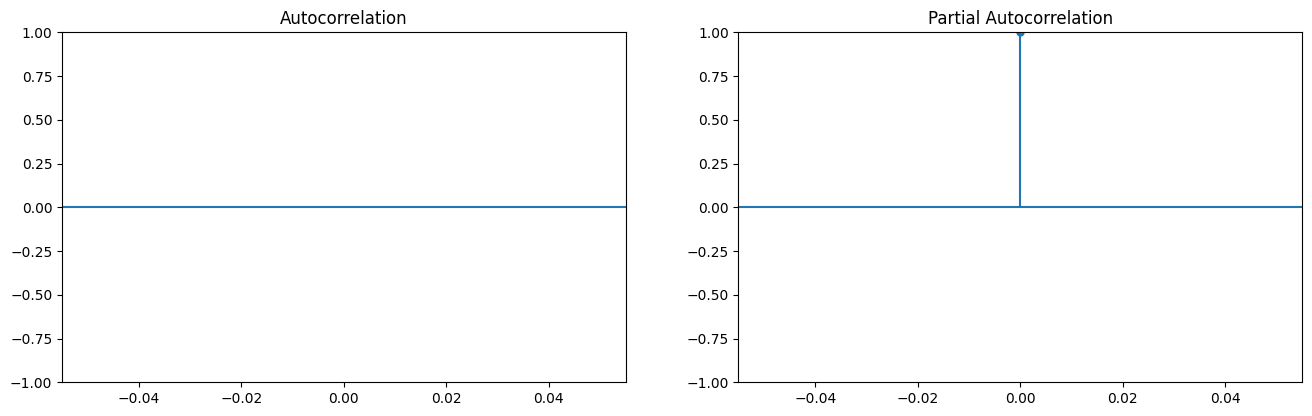

In [ ]:
#correlação e autocorrelação de valores diários (série mensal não há dados suficientes)
def acf_pacf(x):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=40, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=40, ax=ax2)
acf_pacf(df1["total_recebido"])

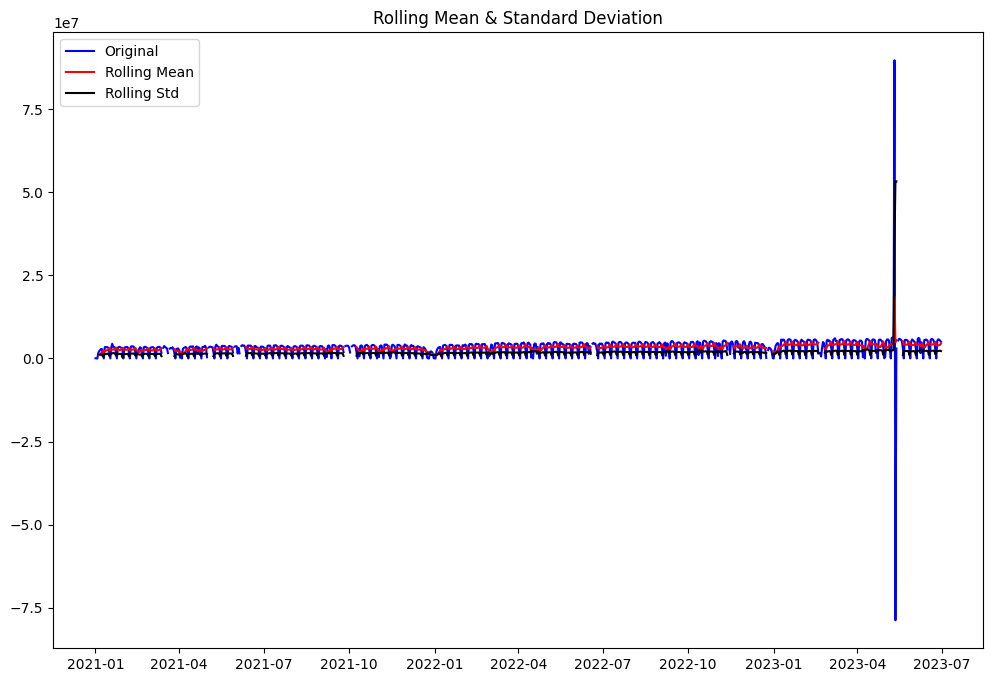

Results of Dickey-Fuller Test:


MissingDataError: exog contains inf or nans

In [ ]:
#Para verificar a estacionáriedade, podemos utilizar o teste ADF.
#O código abaixo cria uma função que irá realizar o teste em nossa variável chave, assim como plotar um gráfico com suas defasagens regredidas. 
def test_stationarity(timeseries, window = 6, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
test_stationarity(df1['total_recebido'])

In [ ]:
#Decomposição das séries para analise estatística 
result = seasonal_decompose(df1['total_recebido'], model='additive')

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(4, 6)

ValueError: This function does not handle missing values

In [ ]:
#Verifica através da estatística de AIC qual melhor nível de parâmetros (p,d,q) para otimizar o modelo.
res = sm.tsa.arma_order_select_ic(df1["total_recebido"], ic=["aic", "bic"], trend="c")
res.aic_min_order
res.bic_min_order

(4, 2)

In [ ]:
mod = sm.tsa.statespace.SARIMAX(df["total_recebido"],
                                order=(4, 2, 3),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

/home/gabriel/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/gabriel/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.17969D+01    |proj g|=  2.89124D+01

At iterate    5    f=  1.68623D+01    |proj g|=  3.81746D-01

At iterate   10    f=  1.67582D+01    |proj g|=  8.88939D-02

At iterate   15    f=  1.67397D+01    |proj g|=  3.33759D-02

At iterate   20    f=  1.67097D+01    |proj g|=  8.33281D-02

At iterate   25    f=  1.66997D+01    |proj g|=  2.55353D-01

At iterate   30    f=  1.66549D+01    |proj g|=  1.08715D+00

At iterate   35    f=  1.65986D+01    |proj g|=  3.19322D-01

At iterate   40    f=  1.65915D+01    |proj g|=  2.11760D-01

At iterate   45    f=  1.65894D+01    |proj g|=  2.67535D-01

At iterate   50    f=  1.65881D+01    |proj g|=  2.66692D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/gabriel/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                      total_recebido   No. Observations:                  927
Model:             SARIMAX(4, 2, 3)x(1, 1, [], 12)   Log Likelihood              -15377.157
Date:                             Fri, 28 Jul 2023   AIC                          30772.314
Time:                                     10:47:24   BIC                          30815.505
Sample:                                          0   HQIC                         30788.816
                                             - 927                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5480      0.025    -62.500      0.000      -1.597      -1.499
ar.L2         -0.9360      

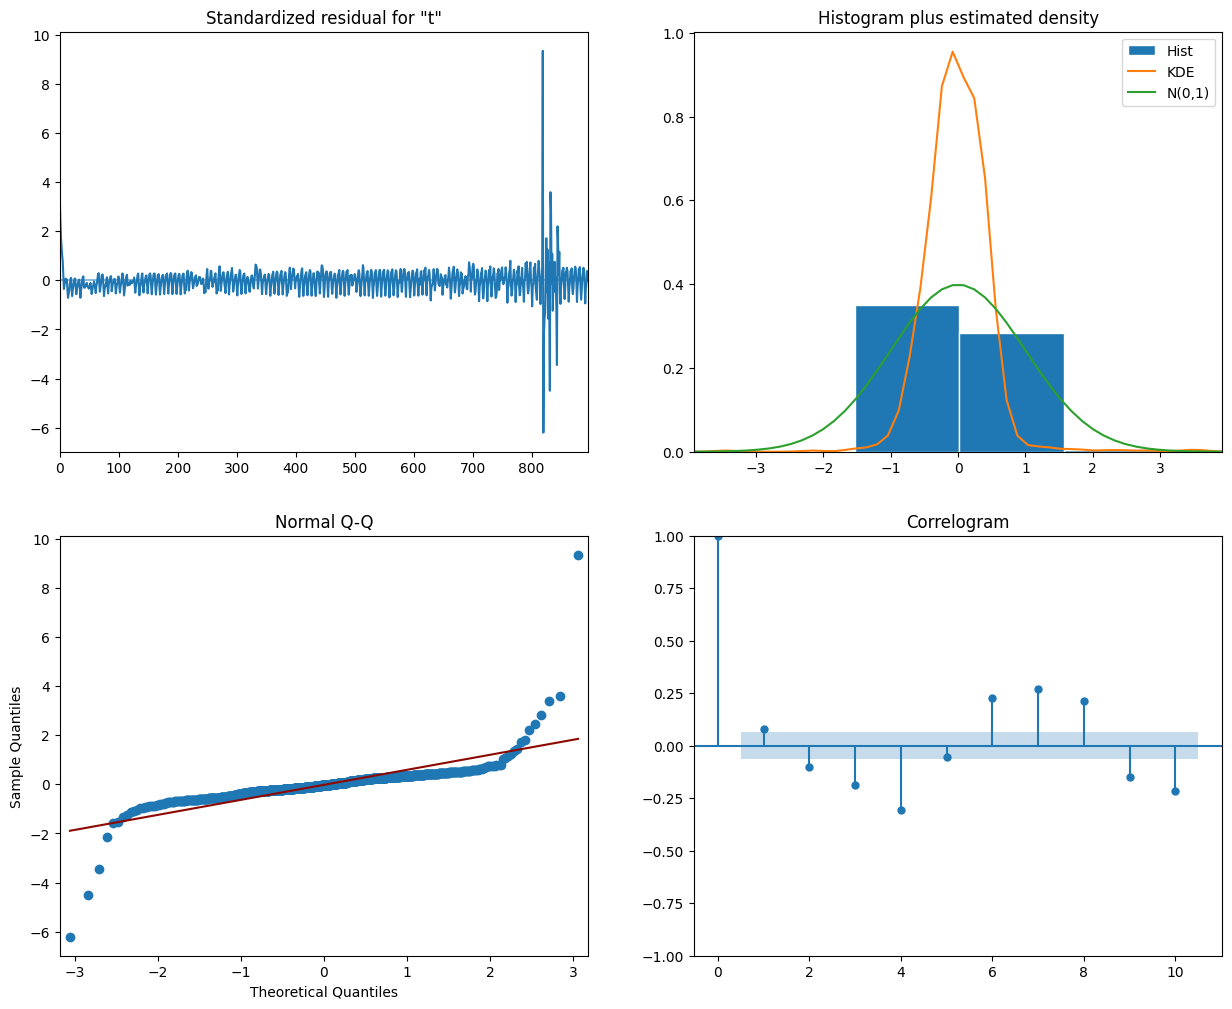

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

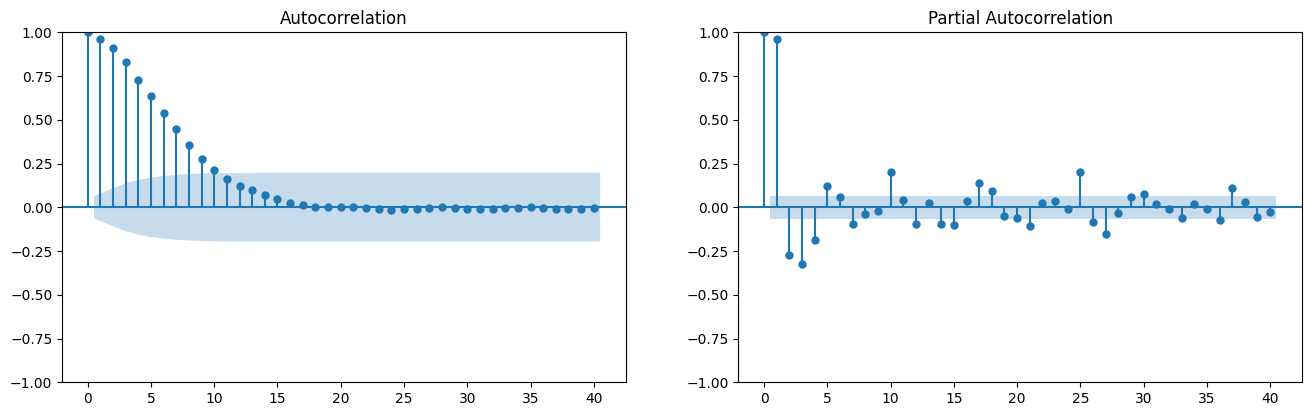

In [ ]:

#gráfico de autocorrelação e autocorrelação parcial, indicando que os resíduos estão não autocorrelacionados, ou seja, são estacionários.
residuals = results.resid
acf_pacf(residuals)

In [ ]:
print(results.mse)
print(results.mae)
print(results.sse)

1505101999154207.5
7770398.988964216
1.3952295532159503e+18


In [ ]:
teste2 = results.forecast(96, alpha=0.05)
teste2.head()

/home/gabriel/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/gabriel/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/gabriel/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


927    7.129702e+06
928    5.953585e+06
929    7.256087e+06
930    3.964224e+06
931    4.179534e+06
Name: predicted_mean, dtype: float64

<Axes: >

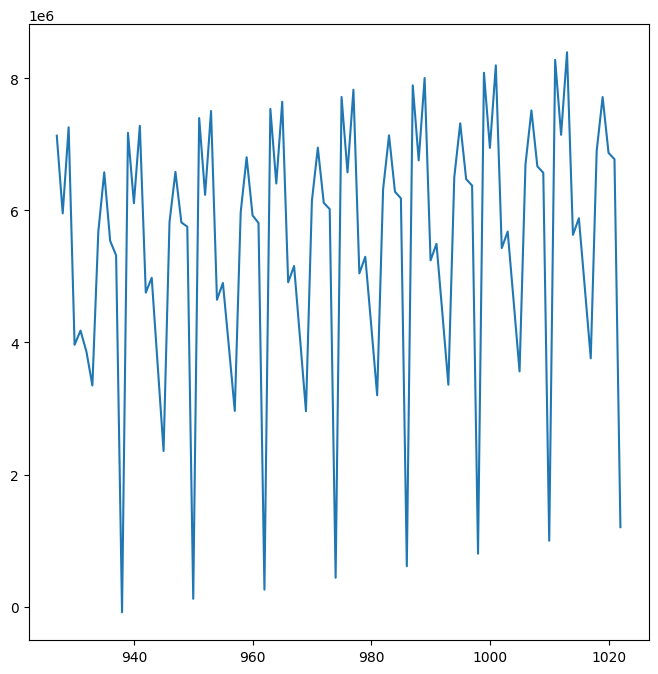

In [ ]:
#Gráfico de projeção
teste2.plot()

In [ ]:
#transformação da série de diário para mensal
df1_monthly = df1.resample('M').sum()
df1_monthly = df1_monthly.sort_values('data')
df1_monthly

,total_recebido
data,
2021-01-31,7.091495e+07
2021-02-28,7.163959e+07
2021-03-31,8.033658e+07
2021-04-30,7.470386e+07
2021-05-31,8.305088e+07
2021-06-30,8.524219e+07
2021-07-31,8.793013e+07
2021-08-31,8.842531e+07
2021-09-30,8.553877e+07


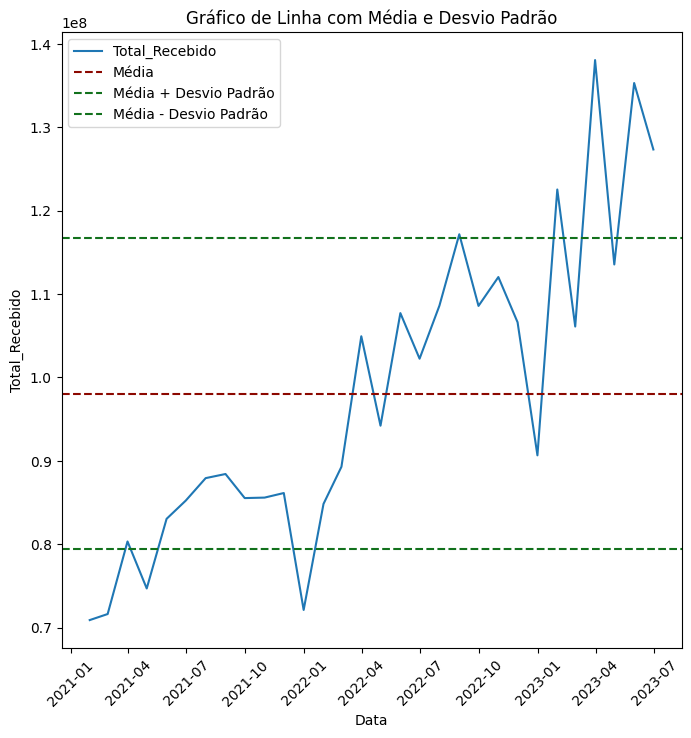

In [ ]:
# Calcular a média e o desvio padrão dos valores de 'Total_Recebido'
mean = df1_monthly['total_recebido'].mean()
std = df1_monthly['total_recebido'].std()

# Plotar o gráfico de linha
plt.plot(df1_monthly['total_recebido'], label='Total_Recebido')

plt.axhline(mean, color='r', linestyle='--', label='Média')
plt.axhline(mean + std, color='g', linestyle='--', label='Média + Desvio Padrão')
plt.axhline(mean - std, color='g', linestyle='--', label='Média - Desvio Padrão')

# Configurar os rótulos e título do gráfico
plt.xlabel('Data')
plt.ylabel('Total_Recebido')
plt.title('Gráfico de Linha com Média e Desvio Padrão')

# Exibir a legenda
plt.legend()

# Girar os rótulos do eixo x para melhor visualização
plt.xticks(rotation=45)

# Exibir o gráfico
plt.show()

<Axes: ylabel='total_recebido'>

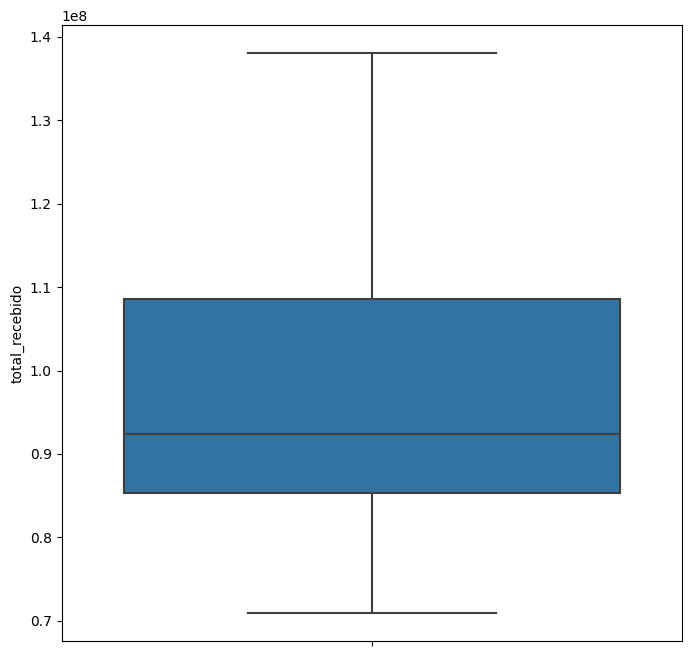

In [ ]:
sns.boxplot(y="total_recebido", data=df1_monthly)

/tmp/ipykernel_2541/842440797.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1_monthly['total_recebido'], color="m", axlabel='Price')


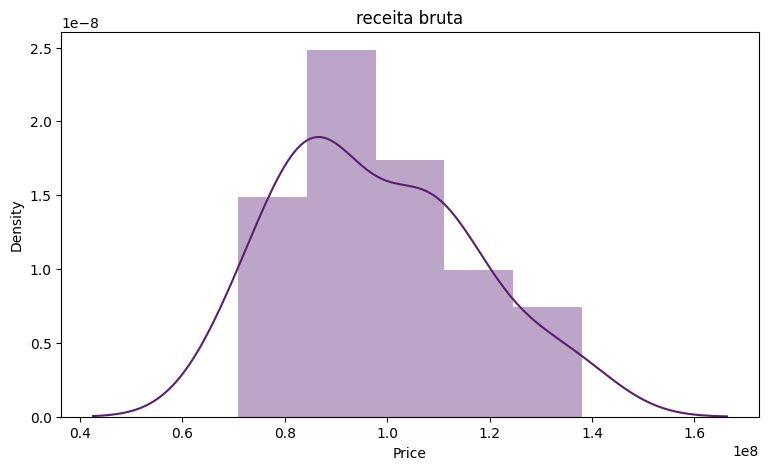

In [ ]:
#distribuição da série mensal
sns.set_color_codes(palette='dark')

f, ax = plt.subplots(figsize=(9, 5))
sns.distplot(df1_monthly['total_recebido'], color="m", axlabel='Price')
ax.set(title="receita bruta")
plt.show()

<Figure size 800x800 with 0 Axes>

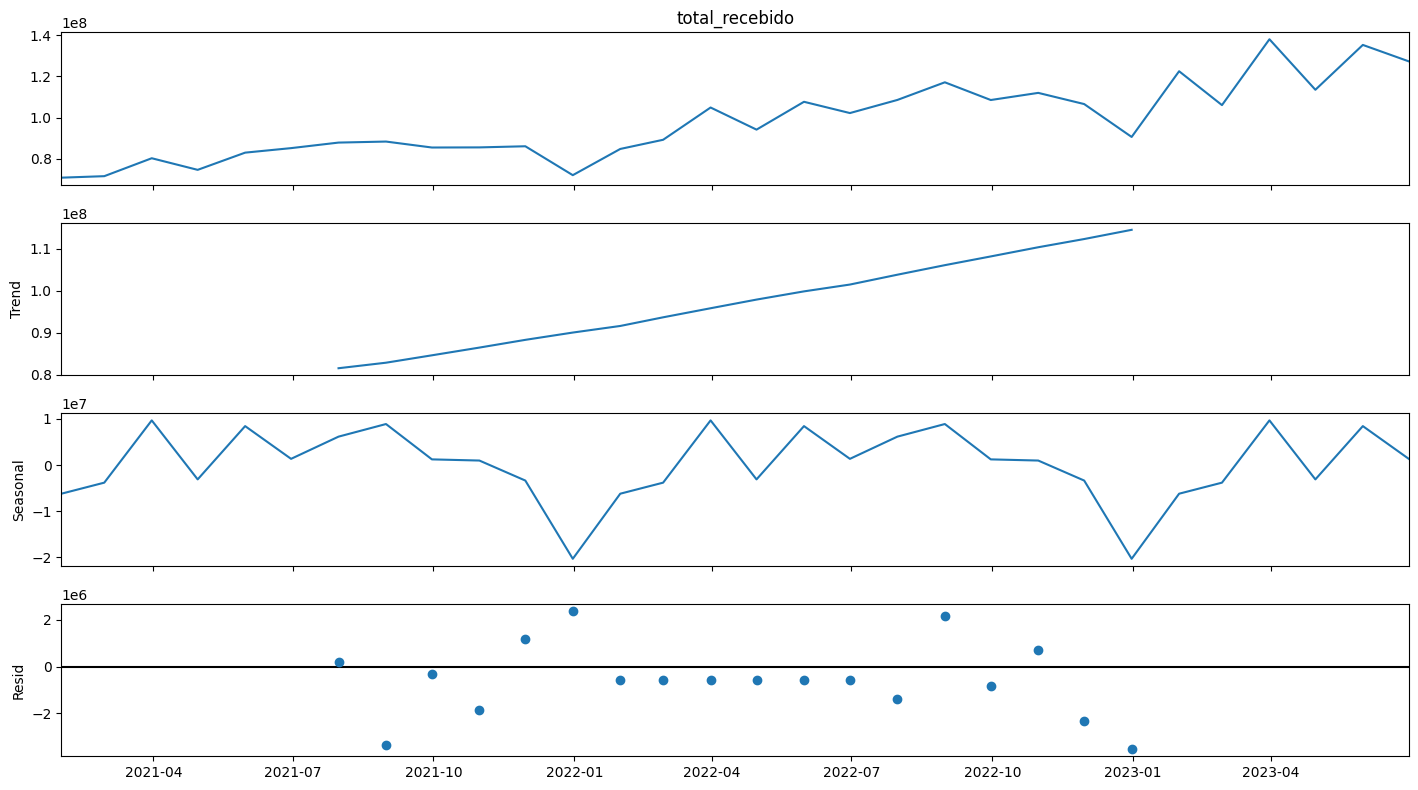

In [ ]:
#Dados até 2022, sendo impossível realizar a decomposição pela falta de mais dados
result = seasonal_decompose(df1_monthly['total_recebido'], model='additive')

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 8)

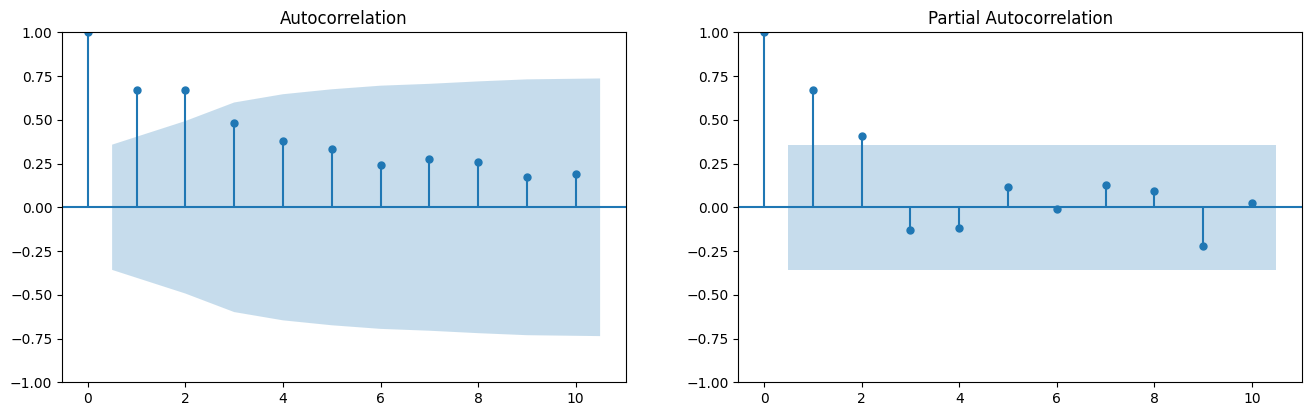

In [ ]:
#correlação e autocorrelação de valores diários (série mensal não há dados suficientes)
def acf_pacf(x):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=10, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=10, ax=ax2)
acf_pacf(df1_monthly["total_recebido"])

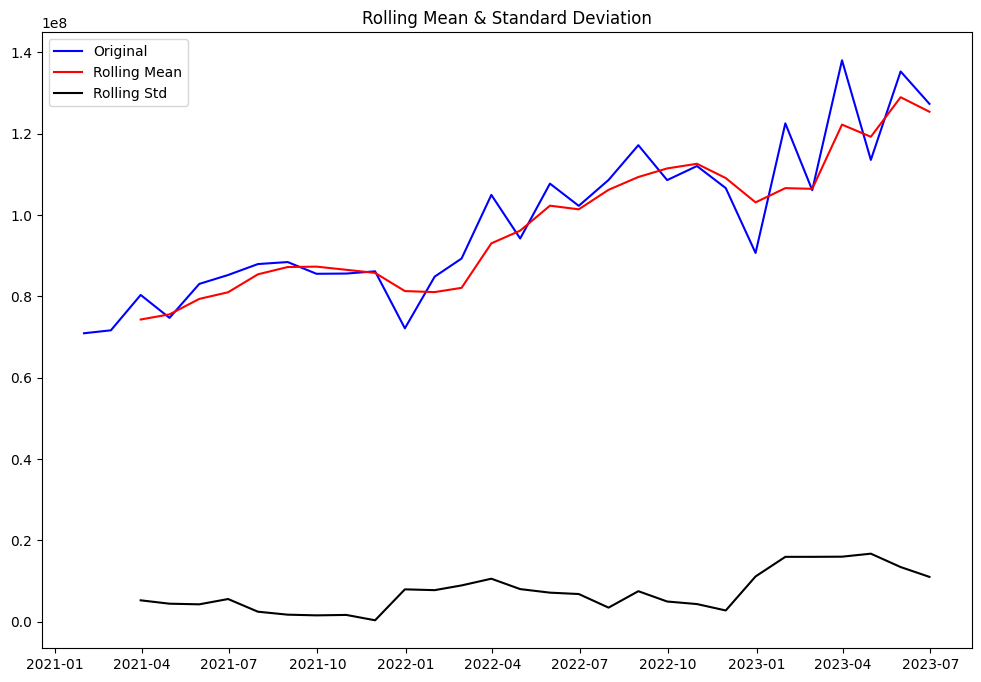

Results of Dickey-Fuller Test:


ValueError: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors

In [ ]:
#Para verificar a estacionáriedade, podemos utilizar o teste ADF.
#O código abaixo cria uma função que irá realizar o teste em nossa variável chave, assim como plotar um gráfico com suas defasagens regredidas. 
def test_stationarity(timeseries, window = 3, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
test_stationarity(df1_monthly['total_recebido'])

In [ ]:

#Verifica através da estatística de AIC qual melhor nível de parâmetros (p,d,q) para otimizar o modelo.
res = sm.tsa.arma_order_select_ic(df1_monthly["total_recebido"], ic=["aic", "bic"], trend="c")
res.aic_min_order
res.bic_min_order

/home/gabriel/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/gabriel/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0)

In [ ]:
mod = sm.tsa.statespace.SARIMAX(df1_monthly["total_recebido"],
                                order=(2, 0, 3),
                                seasonal_order=(1, 1, 0, 6),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_montlhly = mod.fit()

print(results_montlhly.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29673D+07    |proj g|=  6.22745D+06

At iterate    5    f=  1.65012D+01    |proj g|=  1.87445D+02

At iterate   10    f=  9.72356D+00    |proj g|=  5.29771D+00

At iterate   15    f=  9.51693D+00    |proj g|=  4.71301D-01

At iterate   20    f=  9.37212D+00    |proj g|=  1.40114D+00

At iterate   25    f=  9.27764D+00    |proj g|=  1.22687D-01

At iterate   30    f=  9.26349D+00    |proj g|=  2.29266D-01

At iterate   35    f=  9.25769D+00    |proj g|=  6.23849D-02

At iterate   40    f=  9.24236D+00    |proj g|=  2.91135D-01

At iterate   45    f=  9.23848D+00    |proj g|=  6.57399D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


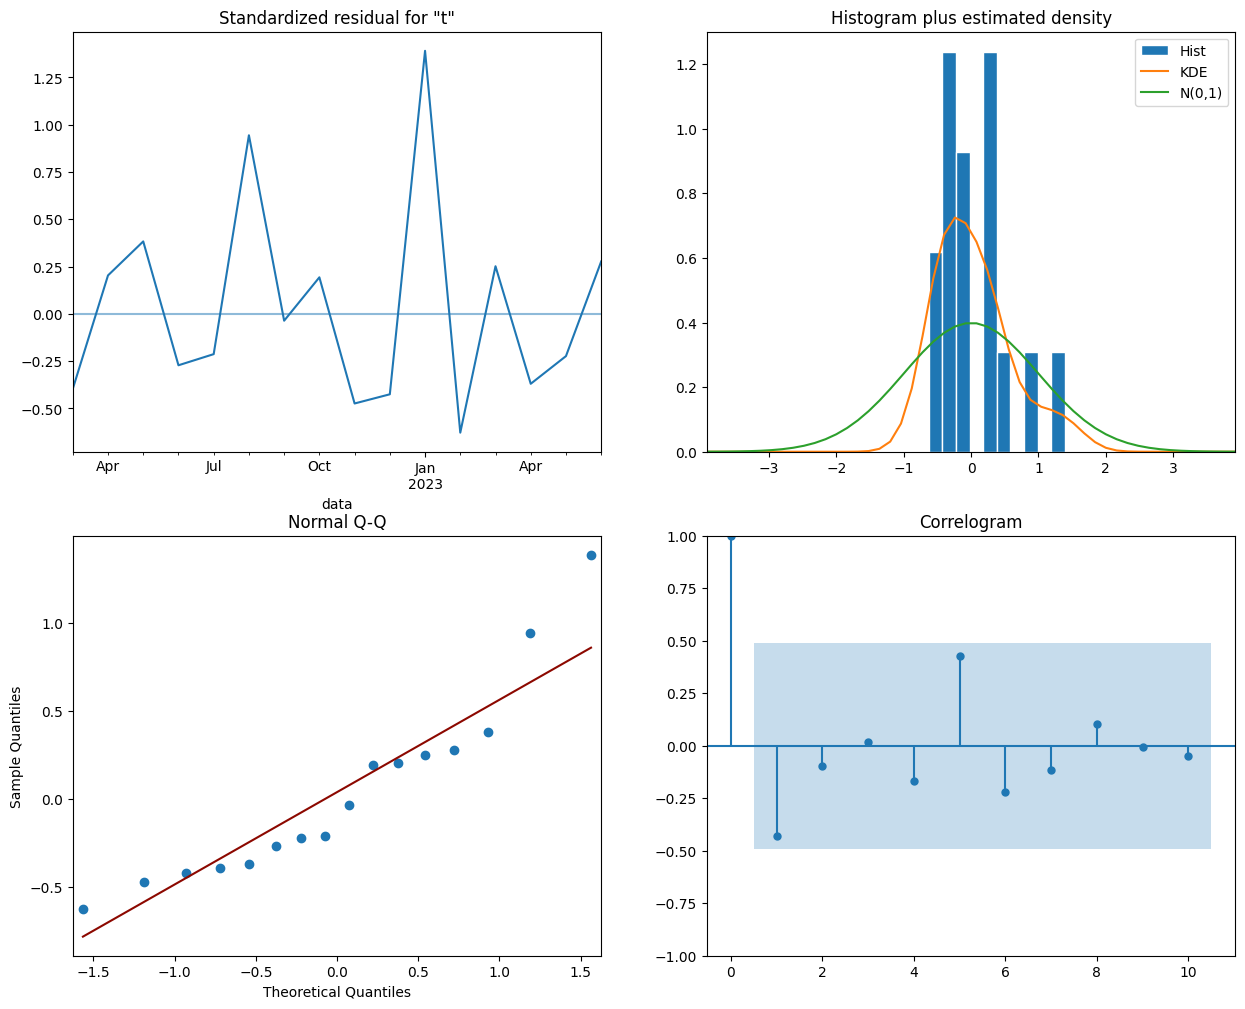

In [ ]:
results_montlhly.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
print(results_montlhly.mse)
print(results_montlhly.mae)
print(results_montlhly.sse)

744704546838019.5
16962078.67378315
2.2341136405140584e+16


In [ ]:
teste2_monthly = results_montlhly.forecast(96, alpha=0.05)
teste2_monthly.head(30)
teste2_monthly = teste2_monthly[:12]

/home/gabriel/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: >

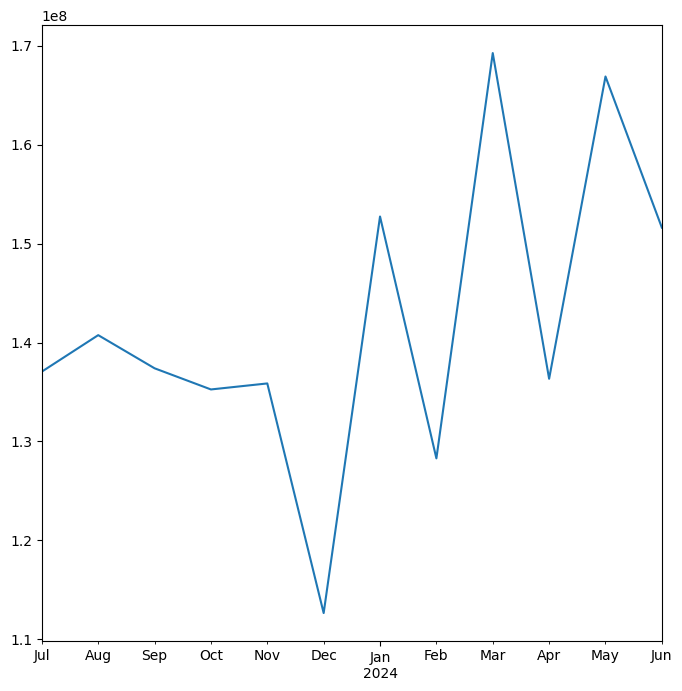

In [ ]:
#Gráfico de projeção
teste2_monthly.plot()

In [ ]:
nome_do_arquivo = 'projecao_AR.xlsx'
teste2_monthly.to_excel(nome_do_arquivo, index=False)  # O argumento 'index=False' evita salvar o índice do DataFrame no Excel

In [ ]:
df1_monthly
nome_do_arquivo = 'df1_monthly.xlsx'
df1_monthly.to_excel(nome_do_arquivo, index=False)  # O argumento 'index=False' evita salvar o índice do DataFrame no Excel